# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: #your answer here

Использование метода predict_proba возвращает вероятности предсказания классов, а не сами предсказания. возьмем вместо него predict

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_binary = random_classifier.predict(X_test)
y_binary


array([0, 1, 0, ..., 0, 1, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#your code here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


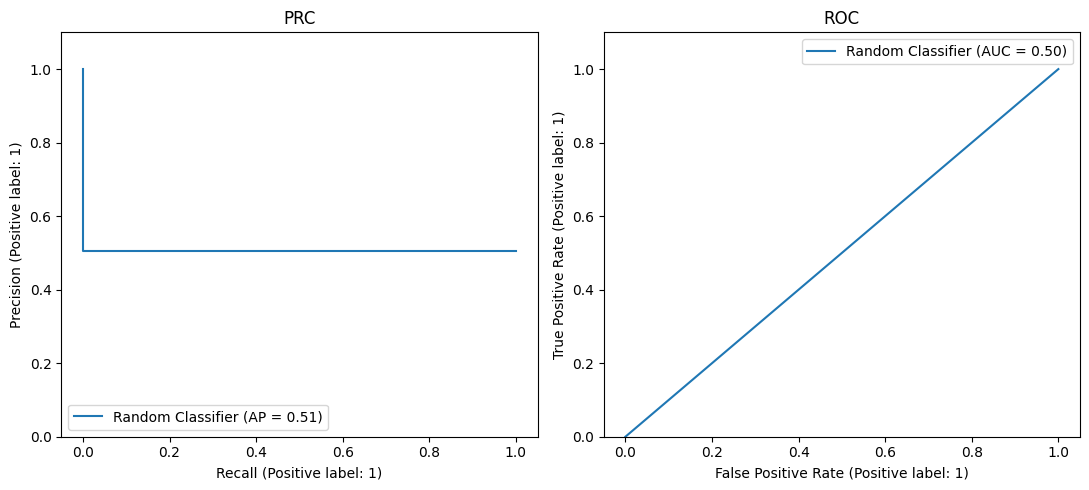

In [6]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [8]:
param_grid = {'C': [0.1, 1, 2, 5, 10]}
scoring = make_scorer(average_precision_score)
svc = SVC(kernel='linear', probability=True)
grid = GridSearchCV(svc, param_grid, cv=5, scoring=scoring)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.1, 1, 2, 5, 10]},
             scoring=make_scorer(average_precision_score))

In [9]:
print(grid.best_params_)


{'C': 0.1}


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

linear metrics
AUC-PR: 0.82969
AUC-ROC: 0.84765


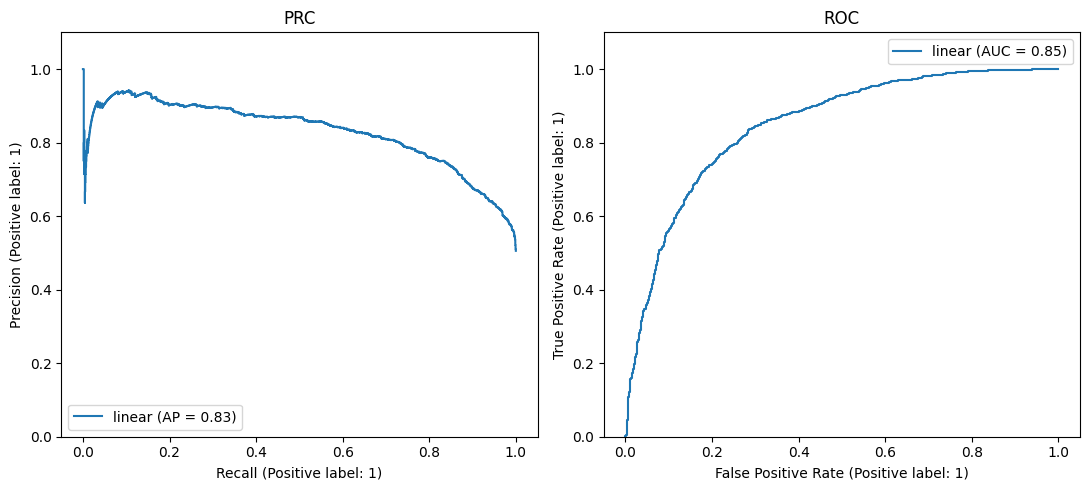

In [10]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
depict_pr_roc(y_test, svc_pred, 'linear')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['SVC'] = [
    auc(recall, precision),
    roc_auc_score(y_test, svc_pred),
    0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.50000,0.0
SVC,0.752833,0.84765,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
#your code here

param_grid = {'C': [0.1, 1, 1.5, 2, 3, 10, 100], 'solver' : ['lbfgs'], 'penalty' : ['l2']}
lg = LogisticRegression()
grid = GridSearchCV(lg, param_grid, refit = True, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 1.5, 2, 3, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [13]:
print(grid.best_params_)

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

logistic metrics
AUC-PR: 0.82912
AUC-ROC: 0.84787


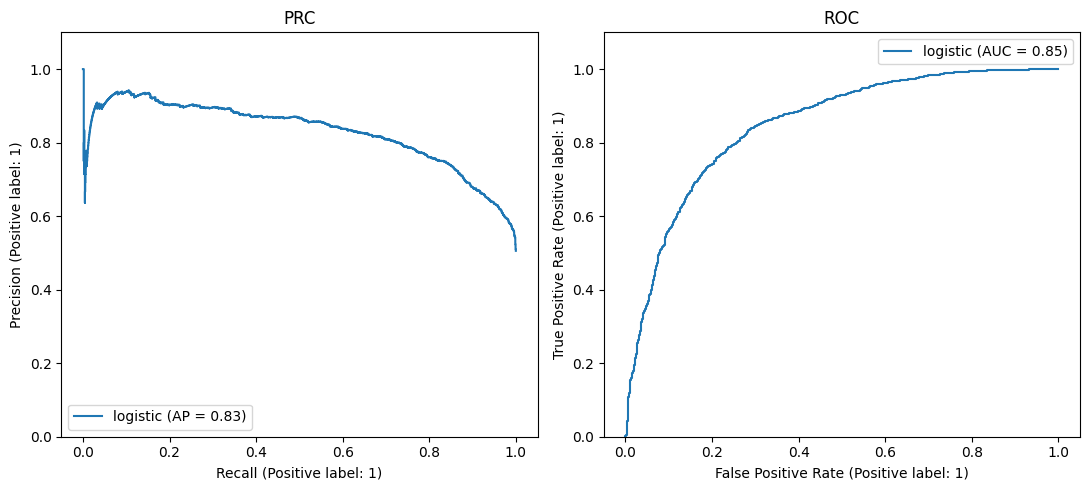

In [14]:
lr = LogisticRegression(max_iter=100000, C=1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
depict_pr_roc(y_test, lr_pred, 'logistic')

In [15]:
def depict_pr_roc_multi(y_true, y_preds, classifier_names):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    for idx, (y_pred, classifier_name) in enumerate(zip(y_preds, classifier_names)):
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        print(classifier_name, 'AUC-PR: %.5f' % auc(recall, precision))

        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
        print(classifier_name, 'AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))

    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



Random AUC-PR: 0.75283
Random AUC-ROC: 0.50000
svc AUC-PR: 0.82969
svc AUC-ROC: 0.84765
logistic AUC-PR: 0.82912
logistic AUC-ROC: 0.84787


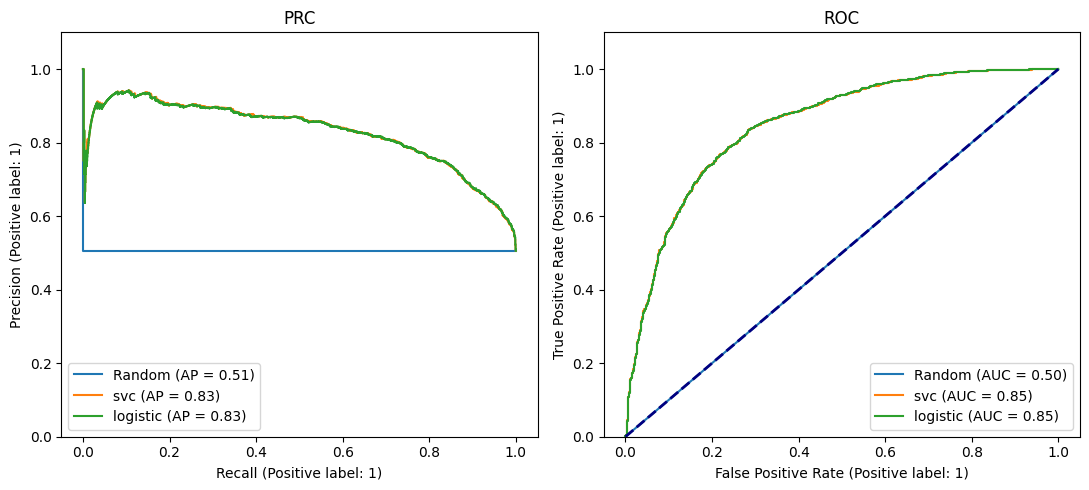

In [16]:
depict_pr_roc_multi(y_test, [y_random, svc_pred, lr_pred], ['Random', 'svc', 'logistic'])

**Ответ:** # your answer here

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [17]:
#your code here
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, class_sep=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
svc = SVC(kernel='linear', probability=True, gamma='auto')
svc.fit(X_train, y_train)


SVC(gamma='auto', kernel='linear', probability=True)

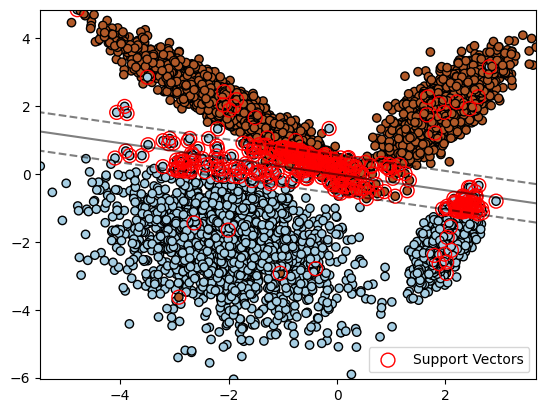

In [19]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                    s=100, linewidth=1, facecolors='none', edgecolors='r', label='Support Vectors')

    plt.legend()

plot_svm_2D(X_train, y_train, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** #your answer here

которые рядом с разделяющей прямой

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [20]:
lr = LogisticRegression(max_iter=100000, C=1).fit(X_train, y_train)

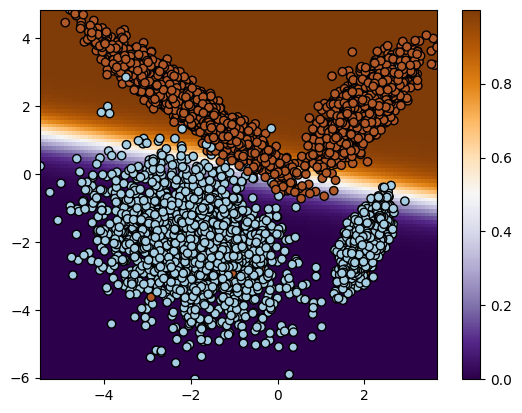

In [21]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    plt.colorbar(image)


plot_logreg_2D(X_train, y_train, lr)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** #your answer here

беленьким, модель не знает куда отнести

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.


Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [22]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #+
        #bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #min -> mean
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)] == 1))

    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [23]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [24]:
model_ = SVC(kernel = 'linear')
model_.fit(X_train, y_train)
model_.decision_function(X_test)

svc_pred = model_.decision_function(X_test)
svc_pred1 = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

lr_pred1 = model_lr.predict_proba(X_test)[:, 1]

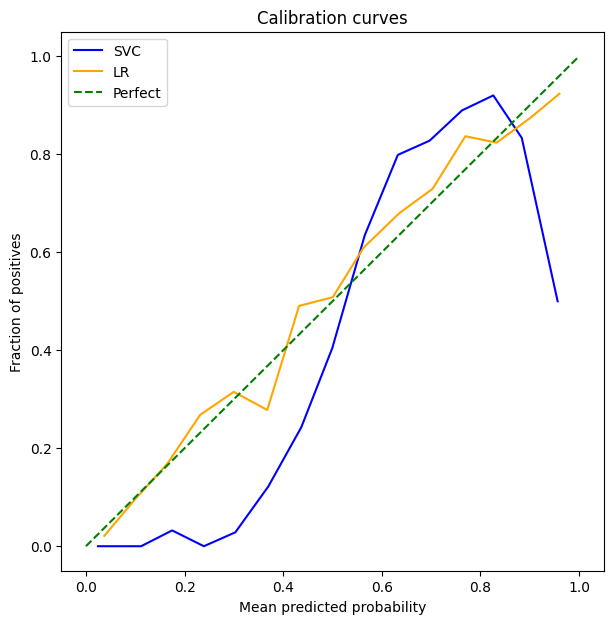

In [25]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred1, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred1, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here
для логрег лучше чем для свм (тк накидывается сигмоида)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

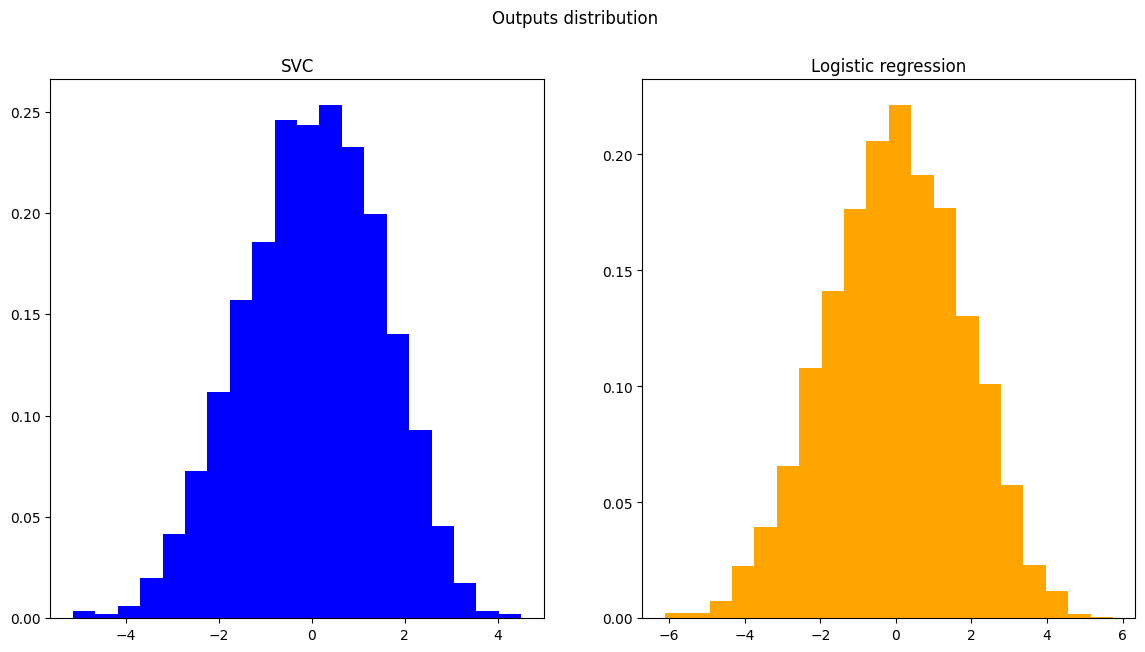

In [26]:

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** #your answer here
Калибровочные кривые соответствуют логике (логрегрессия более корректно оценивает вероятности, что отражается и в том факте, что для нее кривая ближе к диагонали, а для SVM важнее разделение объектов, для нее кривая имеет s-образную форму). Из анализа гистограмм можно сделать вывод, что все супер

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [27]:
#your code here
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8478782385826447


In [28]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8476771016366103


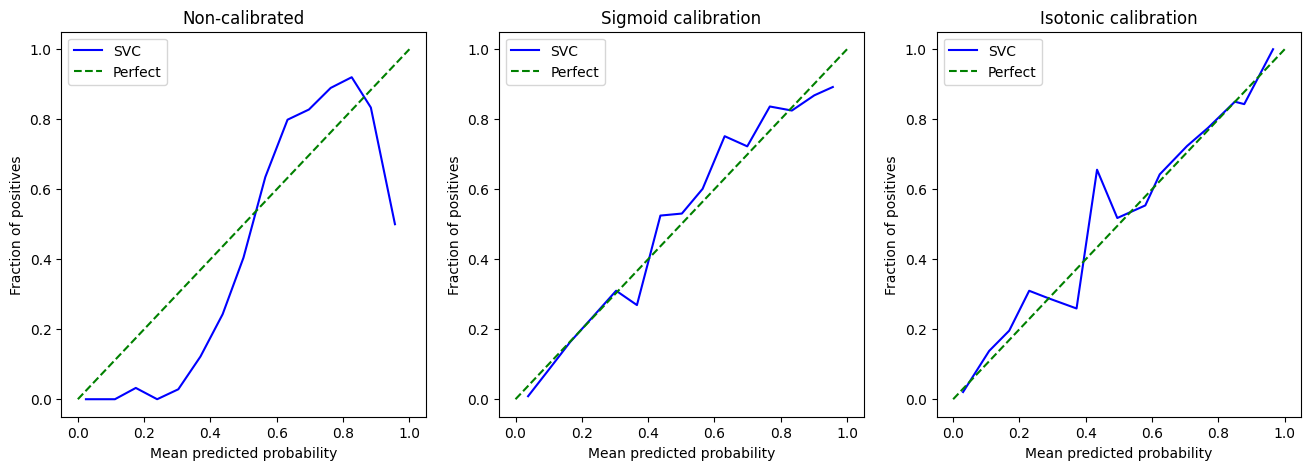

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** #your answer here
улучшилась!

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [30]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [80]:
df = pd.read_csv('bike_buyers.csv')

#Заменим пропуски категориальных переменных
#your code here
for column in df.select_dtypes(include=['object']).columns.tolist():
    df[column].fillna('undefined', inplace=True)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')
y.apply(lambda x: 1 if x == 'yes' else 0)

#Разделим на категориальные признаки и числовые
numerical_columns = X.select_dtypes(include=['int', 'float']).columns.tolist()
X_numerical = df[numerical_columns]
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X_categorical = df[categorical_columns]



В начале поработаем только с категориальными признаками

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [82]:
X_train[categorical_columns].isnull().sum()


Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
dtype: int64

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import time


In [84]:
X_train_categorical = X_train.select_dtypes(include=['object']).columns.tolist()


In [85]:
%%time
column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), X_train_categorical),
])

X_train_ord = column_transformer.fit_transform(X_train)
X_test_ord = column_transformer.fit_transform(X_test)

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_ord, y_train)
y_pred_ord = log_reg.predict_proba(X_test_ord)[:, 1]

print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_ord):.3f}')
print()

Area under pr-rec course is 0.588

CPU times: user 26.4 ms, sys: 0 ns, total: 26.4 ms
Wall time: 28.4 ms


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [86]:
#your code here
%%time
column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), X_train_categorical),
])

column_transform.fit(X)

X_train_ohe = column_transform.transform(X_train)
X_test_ohe = column_transform.transform(X_test)

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_ohe, y_train)
y_pred_ohe = log_reg.predict_proba(X_test_ohe)[:, 1]

print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_ohe):.3f}')
print()

Area under pr-rec course is 0.667

CPU times: user 55.8 ms, sys: 982 µs, total: 56.8 ms
Wall time: 70.5 ms


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [118]:
#your code here
def mean_target_encoding(X, df_temp, column):
    mean_enc = df_temp.groupby(column)['y'].mean()
    X[column+'_mte'] = X[column].map(mean_enc)
    X.drop([column], axis=1, inplace=True)
    return X

In [119]:
from sklearn import metrics

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.585


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [89]:
#your code here

# https://brendanhasz.github.io/2019/03/04/target-encoding.html
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols


    def fit(self, X, y):
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap

        #print(self.maps)
        return self


    def transform(self, X, y=None):
        X_ = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            X_[col] = vals
        return X_


    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [97]:
#your code here
for col in list(map(lambda x: x + '_mte', X_train_categorical)):
    X_train_enc[col] = X_train_enc[col] + np.random.normal(loc=0, scale=0.01, size=X_train_enc.shape[0]) # кодируем train
    X_test_enc[col] = X_test_enc[col] + np.random.normal(loc=0, scale=0.01, size=X_test_enc.shape[0]) # кодируем test

#X_train_enc.head(5)
lr_noise = LogisticRegression(max_iter=1000)
lr_noise.fit(X_train_enc, y_train)
precision, recall, threshold = metrics.precision_recall_curve(y_test, lr_noise.predict_proba(X_test_enc)[:,1])
print('AUC-PR для LR c mean-target encoding с шумом = %.5f' % metrics.auc(recall, precision))

AUC-PR для LR c mean-target encoding с шумом = 0.57863


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** #your answer here
нет(

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [52]:
#your code here
def smoothing_target_encoder(X, df_temp, column, C=10):
    global_mean = df_temp['y'].mean()
    counts = df_temp.groupby(column)['y'].count()
    means = df_temp.groupby(column)['y'].mean()
    smooth = (counts * means + C * global_mean) / (counts + C)

    X[column+'_s_mte'] = X[column].map(smooth)
    X.drop([column], axis=1, inplace=True)
    return X

In [53]:
X_train_s_enc = X_train.copy()
X_test_s_enc = X_test.copy()

tic = time.perf_counter()
for col in columns:
    X_train_s_enc = smoothing_target_encoder(X_train_s_enc, df_temp, col) # кодируем train
    X_test_s_enc = smoothing_target_encoder(X_test_s_enc, df_temp_test, col) # кодируем test

lr_s_mte = LogisticRegression(max_iter=1000)
lr_s_mte.fit(X_train_s_enc, y_train)

toc = time.perf_counter()
time_to_conv = toc - tic
print('Время, потребовавшееся на кодирование + обучение модели:', time_to_conv)
y_pred = lr_s_mte.predict(X_test_s_enc)
precision, recall, threshold = metrics.precision_recall_curve(y_test, lr_s_mte.predict_proba(X_test_s_enc)[:,1])
print('AUC-PR для LR c smoothing mean-target encoding = %.5f' % metrics.auc(recall, precision))

Время, потребовавшееся на кодирование + обучение модели: 0.059477169000274444
AUC-PR для LR c smoothing mean-target encoding = 0.71459


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [116]:
df['Income'].fillna(df['Income'].mean(),inplace=True)
df['Children'].fillna(df['Children'].mean(),inplace=True)
df['Cars'].fillna(df['Cars'].mean(),inplace=True)
df['Age'].fillna(df['Age'].mean(),inplace=True)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')
y.apply(lambda x: 1 if x == 'yes' else 0)

#Разделим на категориальные признаки и числовые
numerical_columns = X.select_dtypes(include=['int', 'float']).columns.tolist()
X_numerical = df[numerical_columns]
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X_categorical = df[categorical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


In [59]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [121]:
categorical_columns5 = ['Marital Status', 'Education',
           'Home Owner', 'Occupation',
           'Commute Distance', 'Region', 'Gender', 'Income',
           'Children', 'Cars', 'Age']

numerical_columns = []

categorical_columns1 = ['Marital Status', 'Education',
           'Home Owner', 'Occupation',
           'Commute Distance', 'Region', 'Gender',]

numerical_columns1 = ['Income']

categorical_columns2 = ['Marital Status', 'Education',
           'Home Owner', 'Occupation',
           'Commute Distance', 'Region', 'Gender']

numerical_columns2 = ['Children']

categorical_columns3 = ['Marital Status', 'Education',
           'Home Owner', 'Occupation',
           'Commute Distance', 'Region', 'Gender',]

numerical_columns3 = ['Cars']

categorical_columns4 = ['Marital Status', 'Education',
           'Home Owner', 'Occupation',
           'Commute Distance', 'Region', 'Gender',]

numerical_columns4 = ['Age']

In [122]:
categorical_columns

['Marital Status',
 'Gender',
 'Education',
 'Occupation',
 'Home Owner',
 'Commute Distance',
 'Region']

In [123]:

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns5
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.475


In [111]:

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns1
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.585


In [115]:

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns2
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.585


In [113]:

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns3
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.585


In [117]:

df_temp = X_train.copy()
df_temp['y'] = y_train
columns = categorical_columns4
X_train_enc = X_train.copy()

df_temp_test = X_test.copy()
df_temp_test['y'] = y_test
X_test_enc = X_test.copy()

for col in columns:
    X_train_enc = mean_target_encoding(X_train_enc, df_temp, col) # кодируем train
    X_test_enc = mean_target_encoding(X_test_enc, df_temp_test, col) # кодируем test

log_reg = LogisticRegression(C=1, max_iter=100000, solver='lbfgs').fit(X_train_enc, y_train)


y_pred_mne = log_reg.predict_proba(X_test_enc)[:, 1]
print(f'Area under pr-rec course is {average_precision_score(y_test, y_pred_mne):.3f}')


Area under pr-rec course is 0.585


In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', mean_te, notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model_lr = pipeline.fit(X_train, y_train)
finish = time.time()

precision, recall, _ = precision_recall_curve(y_test, model_lr.predict_proba(X_test)[:,1])
print('PR-AUC (age and hours are numeric): %.5f' %(auc(recall, precision)))

In [ ]:
#your code here

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты
модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).




Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [124]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 14:36:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.57MB/s    in 0.5s    

2023-11-22 14:36:18 (7.57 MB/s) - ‘adult.data’ saved [3974305]



In [125]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13050,19,Local-gov,202184,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,15,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [126]:
#your code here
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify = y)


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [127]:
#your code here
numeric_features = [
    'age', 'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country'
]
print(X_train.shape)
print(X_test.shape)

(24420, 14)
(8141, 14)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [128]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

#
Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')
print(Xt_test.shape)

model_lr = LogisticRegression(max_iter=500)
param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

search_lr.fit(Xt_train, y_train)

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)
(8141, 108)
Best param found by GridSearchCV with One-Hot-Encoding: {'C': 0.774263682681127}
Having AUC-PR score = 0.7671743839948537
And AUC-PR score on test = 0.7673243590159307


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
#your code here
%%time


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [129]:
#your code here
from scipy import stats

def select_features_t_statistic(X, y, n=40):
    t_values, p_values = stats.ttest_ind(X, y, axis=0)
    t_statistics = pd.Series(t_values, index=X.columns)
    top_n_features = t_statistics.abs().nlargest(n).index
    return top_n_features
top_features = select_features_t_statistic(X, y, n=40)
print(top_features)


ValueError: ignored

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [134]:
#your code here
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numerical = X_train.select_dtypes([np.number]).columns
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])
X_train_w, X_valid_w, y_train_w, y_valid_w = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

X_train_w_t = column_transformer.fit_transform(X_train_w)
X_valid_w_t = column_transformer.transform(X_valid_w)

In [135]:
lr_r = LogisticRegression(max_iter=1000)
lr_r.fit(X_train_w_t, y_train_w)
ran_list = np.argsort(np.abs(lr_r.coef_[0]))[::-1]

qual = []
ind_d = [i for i in range(X_train_w_t.shape[1])]
tic = time.perf_counter()
for i in ran_list:
    ind_d.remove(i)
    lr_feat_rem = LogisticRegression(max_iter=1000)
    lr_feat_rem.fit(X_train_w_t[:,ind_d], y_train_w)
    precision, recall, threshold = metrics.precision_recall_curve(y_valid_w,
                                                                  lr_feat_rem.predict_proba(X_valid_w_t[:,ind_d])[:,1])
    iter_aucpr = metrics.auc(recall, precision)
    qual.append(iter_aucpr)
    if X_train_w_t.shape[1] - len(ind_d) == 40:
        break
print(qual)
print('\n Качество падает с удалением %d-го признака' %np.argmax(qual))
toc = time.perf_counter()
time_to_conv = toc - tic
print('Время, потребовавшееся на отбор признаков:', time_to_conv)

[0.7150754254699053, 0.7150820254153254, 0.7153885639784708, 0.7153209889319763, 0.7153097497093068, 0.7150616455108408, 0.7150453453328106, 0.7149857577126636, 0.7151548069594938, 0.7101327801139357, 0.7095395048159481, 0.6849069484857845, 0.6849197650382484, 0.6848929449950449, 0.685069191566167, 0.6850359144040039, 0.6849783656517404, 0.6848618162094583, 0.6849025261776128, 0.6779948602094794, 0.6778180394536257, 0.6777600655142226, 0.6777224981890837, 0.6781593342741269, 0.678115762763767, 0.6779489002165878, 0.6779732908285159, 0.6769391312110706, 0.6767748192737625, 0.6766097652364164, 0.6767216533507542, 0.6768171435175574, 0.6769463091924749, 0.6768238597818355, 0.6768060086773888, 0.6767914349642536, 0.676796845564491, 0.6765694175993818, 0.6766347791997074, 0.6766104727731023]

 Качество падает с удалением 2-го признака
Время, потребовавшееся на отбор признаков: 21.874049132999062


In [136]:
X_train_t = column_transformer.fit_transform(X_train)
X_test_t = column_transformer.transform(X_test)

new_ind = [i for i in range(X_train_w_t.shape[1])]
for j in range(np.argmax(qual) + 1):
    new_ind.remove(ran_list[j])

lr_best_sc = LogisticRegression(max_iter=1000)
lr_best_sc.fit(X_train_t[:,new_ind], y_train)
precision, recall, threshold = metrics.precision_recall_curve(y_test,
                                                                  lr_best_sc.predict_proba(X_test_t[:,new_ind])[:,1])
print('AUC-PR = %.5f' % metrics.auc(recall, precision))

AUC-PR = 0.71258


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [137]:
#your code here
from collections import OrderedDict
def top_40_modif(model, X_train_mod, X_test_mod):
    buf_dict = {}
    for i, el in enumerate(model.coef_[0]):
        buf_dict[i] = el
    l = []
    for k, v in buf_dict.items():
        if v not in -np.sort(-model.coef_[0])[:40]:
            l.append(k)

    for i in l:
        del buf_dict[i]

    d_sorted = OrderedDict(sorted(buf_dict.items(), key=lambda x: x[1], reverse=True))
    return X_train_mod[:, list(buf_dict.keys())], X_test_mod[:, list(buf_dict.keys())], list(d_sorted.keys())

In [138]:
X_train_w, X_valid_w, y_train_w, y_valid_w = train_test_split(X_train, y_train, test_size=0.2,
                                                              random_state=777, stratify=y_train)
X_train_ohe_add = column_transformer.fit_transform(X_train_w)
X_test_ohe_add = column_transformer.transform(X_valid_w)

lr_a = LogisticRegression(max_iter=1000)
lr_a.fit(X_train_ohe_add, y_train_w)

X_train_ohe_add, X_test_ohe_add, top_list = top_40_modif(lr_a, X_train_ohe_add, X_test_ohe_add)

qual1 = []
for i in range(1, 41):
    lr_feat_add = LogisticRegression(max_iter=1000)
    lr_feat_add.fit(X_train_ohe_add[:,:i], y_train_w)
    precision, recall, threshold = metrics.precision_recall_curve(y_valid_w,
                                                                  lr_feat_add.predict_proba(X_test_ohe_add[:,:i])[:,1])
    iter_aucpr = metrics.auc(recall, precision)
    qual1.append(iter_aucpr)

#print(qual)

for i, x in enumerate(qual1):
    if all([x > el for el in qual1[i+1:]]) and i < len(qual1)-1:
        print('Существует порог (качество, число признаков):', x, i)
        break
    elif i == len(qual1)-1:
        print('Порога в данном случае нет')
        print('Итоговое качество: %.5f' %x)

Порога в данном случае нет
Итоговое качество: 0.77099


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [139]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 18:36:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.37MB/s    in 0.3s    

2023-11-22 18:36:02 (1.37 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [155]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [152]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
y.apply(lambda x: 1 if x == 'yes' else 0)

0        0
1        0
2        0
3        0
4        0
        ..
41183    0
41184    0
41185    0
41186    0
41187    0
Name: y, Length: 41188, dtype: int64

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [142]:
# your code here
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [164]:
# your code here
categorical_features = [
    'job', 'marital', 'education', 'default',
    'loan', 'contact', 'month', 'day_of_week', 'campaign',
    'previous', 'poutcome'
]
numeric_features = [
    'age', 'pdays', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m',
    'nr.employed'
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('standard_scaler', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline([
    ('column_transform', column_transformer),
    ('log_reg', LogisticRegression(max_iter=500))
])

auc_pr_scores = []
for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)

    auc_pr_scores.append(precision_recall_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1]))
print((auc_pr_scores))


[(array([0.11313426, 0.11314799, 0.11316173, ..., 1.        , 1.        ,
       1.        ]), array([1.        , 1.        , 1.        , ..., 0.00214592, 0.00107296,
       0.        ]), array([0.00829513, 0.00835845, 0.0091496 , ..., 0.88864953, 0.89099099,
       0.89872362])), (array([0.11143481, 0.11144834, 0.11146187, ..., 1.        , 1.        ,
       1.        ]), array([1.        , 1.        , 1.        , ..., 0.00217865, 0.00108932,
       0.        ]), array([0.00559452, 0.00685911, 0.00695919, ..., 0.8908819 , 0.89192393,
       0.9013357 ])), (array([0.1137412 , 0.11375501, 0.11376882, ..., 1.        , 1.        ,
       1.        ]), array([1.        , 1.        , 1.        , ..., 0.00213447, 0.00106724,
       0.        ]), array([0.00847268, 0.0087989 , 0.00978781, ..., 0.89076788, 0.89285297,
       0.89435554])), (array([0.10707782, 0.10709082, 0.10710383, ..., 0.5       , 0.        ,
       1.        ]), array([1.        , 1.        , 1.        , ..., 0.00113379, 0.

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [162]:
# your code here
revenues, profits = [], []

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    predict = pipe_lr.predict(X_test)

    revenues.append(10 * ((predict == 1) & (predict == y_test)).sum())
    profits.append(revenues[-1] - predict.sum())

revenue_mean = np.mean(revenues)
revenue_std = np.std(revenues)
profit_mean = np.mean(profits)
profit_std = np.std(profits)

print(f'Mean revenue: {revenue_mean}; revenue standard deviation: {revenue_std}')
print(f'Mean profit: {profit_mean}; profit standard deviation: {profit_std}')

Mean revenue: 2132.0; revenue standard deviation: 96.0
Mean profit: 1806.8; profit standard deviation: 96.93379183752175


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент
будет приносить не 10 долларов, а случайную величину, равномерно распределенную
в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [167]:
#your code here
from numpy import random

revenues, profits = [], []

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    predict = pipe_lr.predict(X_test)

    revenue = ((predict == 1) & (predict == y_test)).sum()
    client_income = np.random.uniform(0, 20, revenue.shape)
    revenue *= client_income
    revenues.append(revenue)
    profits.append(revenues[-1] - predict.sum())

revenue_mean = np.mean(revenues)
revenue_std = np.std(revenues)
profit_mean = np.mean(profits)
profit_std = np.std(profits)

print(f'Mean revenue: {revenue_mean}; revenue standard deviation: {revenue_std}')
print(f'Mean profit: {profit_mean}; profit standard deviation: {profit_std}')

Mean revenue: 2020.5398909071423; revenue standard deviation: 1310.6817701060884
Mean profit: 1695.3398909071425; profit standard deviation: 1315.291336007842


ну видно что отклонение пипец возросло что логично

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации
прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [173]:
param_grid = np.logspace(-4, 3, 10)
best_profit, best_param = 0.0, 0.0

for param in param_grid:
    pipe_lr.set_params(**{'log_reg__C': param})
    revenues, profits = [], []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        pipe_lr.fit(X_train, y_train)
        predict = pipe_lr.predict(X_test)

        revenue = ((predict == 1) & (predict == y_test)).sum()
        client_income = np.random.uniform(0, 20, revenue.shape)
        revenue *= client_income
        profits.append(revenue - predict.sum())

    mean_profit = np.mean(profits)
    if best_profit < mean_profit:
        best_profit, best_param = mean_profit, param

print(f'Best param found by CV: {best_param}')
print(f'Best mean profit: {best_profit}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best param found by CV: 0.774263682681127
Best mean profit: 2781.6269942797044


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best param found by CV: 4.641588833612782
Best mean profit: 2673.383522798486


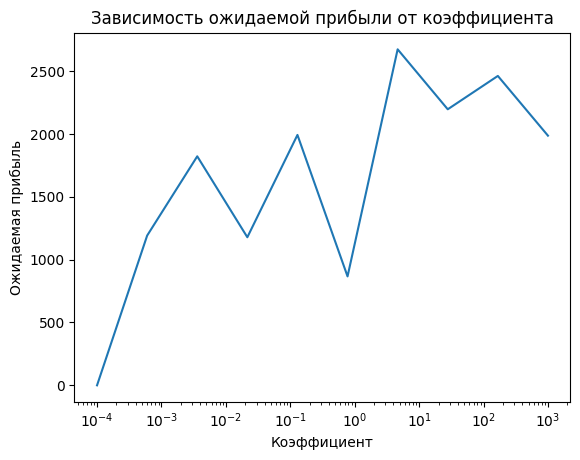

In [187]:
import numpy as np
import matplotlib.pyplot as plt

param_grid = np.logspace(-4, 3, 10)
best_profit, best_param = 0.0, 0.0
profits = []

for param in param_grid:
    pipe_lr.set_params(**{'log_reg__C': param})
    revenues = []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        pipe_lr.fit(X_train, y_train)
        predict = pipe_lr.predict(X_test)

        revenue = ((predict == 1) & (predict == y_test)).sum()
        client_income = np.random.uniform(0, 20, revenue.shape)
        revenue *= client_income
        revenues.append(revenue - predict.sum())

    mean_profit = np.mean(revenues)
    profits.append(mean_profit)
    if best_profit < mean_profit:
        best_profit, best_param = mean_profit, param

print(f'Best param found by CV: {best_param}')
print(f'Best mean profit: {best_profit}')

# Построение графика
plt.plot(param_grid, profits)
plt.xscale('log')
plt.xlabel('Коэффициент')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость ожидаемой прибыли от коэффициента')
plt.show()


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

[1916.7740331793989,
 -177.5423843166113,
 154.0747601539207,
 1977.5948859985374,
 856.1669234191122]

In [ ]:
#your code here
в районе 0,77 получается всегда лучший коэффициент

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here

recall, поскольку важно выявить как можно больше положительных объектов (клиентов, которые согласятся)


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [185]:
#your code here
from sklearn.metrics import precision_score,recall_score

best_profit, best_threshold = 0.0, 0.0
mean_profits, mean_revenues = [], []
mean_precisions, mean_recalls = [], []
stats = []

for threshold in np.linspace(0, 1, 100):
    best_cur_profit, best_cur_param = 0.0, 0.0
    sum_cv_profit = 0.0

    revenues, profits = [], []
    precisions, recalls = [], []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        pipe_lr.fit(X_train, y_train)
        proba = pipe_lr.predict_proba(X_test)[:, 1]
        predict = np.where(proba > threshold, 1, 0)


        revenue = ((predict == 1) & (predict == y_test)).sum()
        client_income = np.random.uniform(0, 20, revenue.shape)
        revenue *= client_income
        revenues.append(revenue)
        profits.append(revenues[-1] - predict.sum())
        precisions.append(precision_score(y_test, predict))
        recalls.append(recall_score(y_test, predict))

    mean_revenues.append(np.mean(revenues))
    mean_profits.append(np.mean(profits))
    mean_precisions.append(np.mean(precisions))
    mean_recalls.append(np.mean(recalls))

    stats.append({
        'threshold': threshold,
        'mean_revenue': mean_revenues[-1],
        'mean_profit': mean_profits[-1],
        'mean_precision': mean_precisions[-1],
        'mean_recall': mean_recalls[-1]
    })

    if best_profit < mean_profits[-1]:
        best_profit, best_threshold = mean_profits[-1], threshold

print(f'Best threshold found by CV: {best_threshold}')
print(f'Best mean profit: {best_profit}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best threshold found by CV: 0.19191919191919193
Best mean profit: 7243.753185289383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




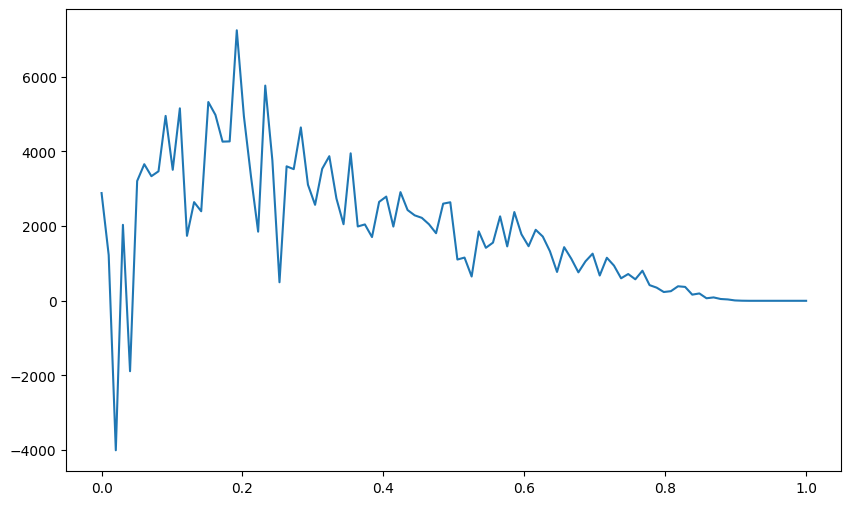

In [186]:
#your code here
fig = plt.figure(figsize=(10, 6))
plt.errorbar(np.linspace(0, 1, 100), mean_profits)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here

омлет с грибами помидорами сыром и НЕ ПОВЕРИТЕ с яйцами запивая кофием